# i-Scream 데이터 분석

## data types
- DKT에서 하나의 행 == interaction

userID
- 사용자 별 고유번호
- 총 6698명의 unique

assessmentitemID
- 사용자가 푼 문항의 일련 번호
- 9,454개의 unique
- 규칙
    - 첫 자리는 A
    - 그 다음 6자리 시험지 번호
    - 마지막 3자리는 시험지 내 문항의 번호

testID
- 시험지의 일련 번호
- 1537개의 unique
- 규칙
    - 첫 자리는 A
    - 첫 자리 3개 + 마지막 3개 는 시험지 번호
    - 가운데는 날려도 괜찮음.
    - 앞의 3자리에서 가운데만 1~9

answerCode
- 정답/오답 여부
- 정답이 약 65%

Timestamp
- 사용자가 interaction을 시작한 시간

KnowleadgeTag
- 문항의 중분류
- 912개의 unique

In [65]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import warnings
warnings.filterwarnings('ignore')

In [67]:
import sys, matplotlib

print("="*5 ,"나의 라이브러리 버전 확인", "="*5)
print(f"{'python version':15s} <> {sys.version}")
print(f"{'pandas version':15s} <> {pd.__version__}")

===== 나의 라이브러리 버전 확인 =====
python version  <> 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
pandas version  <> 1.5.3


In [68]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}

data_dir = '/content/drive/MyDrive/workspace/kaggle&github/네부캠/경진대회_2차/data/' # 경로는 상황에 맞춰서 수정해주세요!
csv_file_path = os.path.join(data_dir, 'train_data.csv') # 데이터는 대회홈페이지에서 받아주세요 :)
df= pd.read_csv(data_dir + 'train_data.csv', dtype=dtype, parse_dates=['Timestamp'])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)



CPU times: user 6.44 s, sys: 1.44 s, total: 7.88 s
Wall time: 10.5 s


In [30]:
df.head(1)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224


In [31]:
def feature_engineering(df):

    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)

    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_sum']

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")

    return df

In [ ]:
df = feature_engineering(df)
df.head(1)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,cumulative,paper_number,test_type,...,paper_number_percent,paper_type_percent,KnowledgeTag_percent,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,3.0,1.0,1,A,...,0.749916,0.709232,0.955022,NaN,0,NaN,0.947683,1268,0.955022,637
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,8.0,1.0,2,A,...,0.720062,0.709232,0.913187,1.0,1,1.0,0.947683,1268,0.913187,3040
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,7.0,1.0,3,A,...,0.687773,0.709232,0.913187,2.0,2,1.0,0.947683,1268,0.913187,3040
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0,1.0,4,A,...,0.663364,0.709232,0.913187,3.0,3,1.0,0.947683,1268,0.913187,3040
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,11.0,1.0,5,A,...,0.599134,0.709232,0.913187,4.0,4,1.0,0.947683,1268,0.913187,3040


In [32]:
diff_train = df.loc[:, ['userID','Timestamp']].groupby('userID').diff().shift(-1)
diff_train = diff_train['Timestamp'].apply(lambda x : x.total_seconds())
df['elapsed'] = diff_train

In [33]:
df.groupby('userID').apply(lambda x :x.iloc[:-1])

outlier = 1*3600
non_outlier = df[df['elapsed'] <= outlier]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum,elapsed
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,0.947683,1268,0.955022,637,3.0


In [34]:
mean_elapsed = non_outlier.groupby('KnowledgeTag')['elapsed'].mean()
df.loc[df['elapsed'] > outlier, 'elapsed'] = df[df['elapsed'] > outlier].apply(lambda x: mean_elapsed.get(x['KnowledgeTag'], x['elapsed']), axis=1)

In [35]:
# 누적합
_cumsum = df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumsum'})
# 누적갯수
_cumcount = df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumcount'}) + 1

cum_ans = _cumsum / _cumcount
df['cumulative'] = cum_ans['answerCode']

df['paper_number'] = df['assessmentItemID'].apply(lambda x: x[7:]) # assessmentItemID의 뒤에 3자리를 의미 -> 각 시험지 별로 문제번호
# item 열을 int16으로 변경
df["paper_number"] = df["paper_number"].astype("int16")

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum,elapsed,cumulative,paper_number
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,0.947683,1268,0.955022,637,3.0,1.0,1


In [69]:
def avg_percent(x) :
    return np.sum(x) / len(x)

In [70]:
def test_type(x) :
    return  x[0]
def paper_type(x) :
    return x[2]
def paper_subtype(x) :
    return x[4:7]


df['test_type'] = df['assessmentItemID'].apply(test_type)
df['paper_type'] = df['assessmentItemID'].apply(paper_type).astype(int)
df['paper_subtype'] = df['assessmentItemID'].apply(paper_subtype).astype(int)


In [72]:
df['paper_number_percent'] = df.groupby('paper_number')['answerCode'].transform(avg_percent)
df['paper_type_percent'] = df.groupby('paper_type')['answerCode'].transform(avg_percent)
df['KnowledgeTag_percent'] = df.groupby('KnowledgeTag')['answerCode'].transform(avg_percent)

In [39]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):

    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)

    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [73]:
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test_type,paper_type,paper_subtype,KnowledgeTag_percent
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,A,6,1,0.955022
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,A,6,1,0.913187
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,A,6,1,0.913187
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,A,6,1,0.913187
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,A,6,1,0.913187


In [74]:
df.KnowledgeTag.value_counts()

7597    12892
7600    10734
2010    10176
7621     9709
8127     9006
        ...  
5142       47
2871       46
4978       46
7125       45
2613       44
Name: KnowledgeTag, Length: 912, dtype: int64

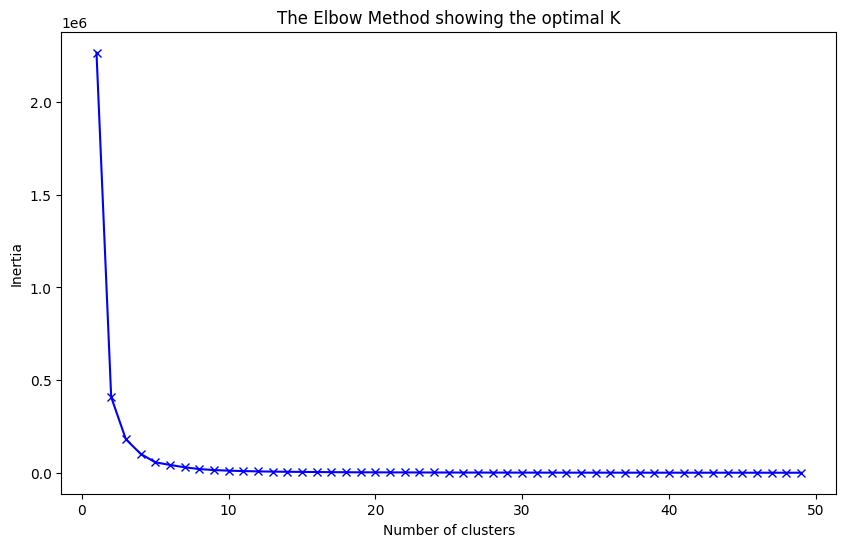

In [83]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans


x = df[['KnowledgeTag']]
scaler = StandardScaler()
scaled = scaler.fit_transform(x)

inertia = []

Km = range(1,50)
for k in Km :
    kmeans = KMeans(n_clusters = k, random_state=42)
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(Km, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal K')
plt.show()

In [86]:
x = df[['KnowledgeTag']]
# one hot encoding을 통해 multi hot encoding 진행
encoder = OneHotEncoder()
x_encode = encoder.fit_transform(x)

# 적절한 차원을 찾기 위해 k-means로 대략적으로 확인


pca = PCA(n_components=1)
df['KnowledgeTag_pca'] = pca.fit_transform(x)

ValueError: n_components=5 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

In [49]:
df['elapsed'] = df['elapsed'].fillna(0)

X = df[['KnowledgeTag', 'elapsed', 'cumulative','paper_number','paper_type', 'paper_subtype', 'paper_number_percent',
       'paper_type_percent', 'KnowledgeTag_percent']]

pca = PCA(n_components=1)
df['elapsed_pca'] = pca.fit_transform(X)

In [50]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,cumulative,paper_number,test_type,paper_type,paper_subtype,paper_number_percent,paper_type_percent,KnowledgeTag_percent,elapsed_pca
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,3.000000,1.000000,1,A,6,1,0.749916,0.709232,0.955022,2314.929911
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,8.000000,1.000000,2,A,6,1,0.720062,0.709232,0.913187,2315.927052
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,7.000000,1.000000,3,A,6,1,0.687773,0.709232,0.913187,2315.927633
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.000000,1.000000,4,A,6,1,0.663364,0.709232,0.913187,2315.927641
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,11.000000,1.000000,5,A,6,1,0.599134,0.709232,0.913187,2315.925355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,96.586217,0.200000,5,A,3,71,0.599134,0.702238,0.689706,-4471.025784
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,11.000000,0.333333,1,A,4,165,0.749916,0.684056,0.697874,3927.136491
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,46.000000,0.428571,2,A,4,165,0.720062,0.684056,0.697874,3927.116434
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,73.000000,0.500000,3,A,4,165,0.687773,0.684056,0.697874,3927.100964


# lgbm

https://www.kaggle.com/code/mlisovyi/lightgbm-hyperparameter-optimisation-lb-0-761

In [62]:
# 유저별 분리
train, test = custom_train_test_split(df)

# 사용할 Feature 설정
# FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer',
#          'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum',
#          'elapsed','cumulative','paper_number_percent','paper_type_percent','KnowledgeTag_percent'
#          ]

FEATS = ['KnowledgeTag','paper_number','paper_type','paper_subtype',
         'elapsed','cumulative','paper_number_percent',
         'paper_type_percent','KnowledgeTag_percent','elapsed_pca'
         ]


# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [53]:
FEATS

['KnowledgeTag',
 'elapsed',
 'cumulative',
 'paper_number_percent',
 'paper_type_percent',
 'KnowledgeTag_percent',
 'elapsed_pca']

In [ ]:
!pip install lightgbm

In [54]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [63]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

In [64]:
# model = lgb.train(
#     {'objective': 'binary'},
#     lgb_train,
#     valid_sets=[lgb_train, lgb_test],
#     num_boost_round=500,
# )

model = lgb.train(
    {
        'objective': 'binary',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': 10,
        'min_data_in_leaf': 20,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 5,
        'lambda_l1': 0.1,
        'lambda_l2': 0.1
    },
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    num_boost_round=500,
)



preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1034940, number of negative: 551661
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1522
[LightGBM] [Info] Number of data points in the train set: 1586601, number of used features: 10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.652300 -> initscore=0.629165
[LightGBM] [Info] Start training from score 0.629165
VALID AUC : 0.729544582295534 ACC : 0.66765578635

test에 적용

In [ ]:
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}

# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path, dtype=dtype, parse_dates=['Timestamp'])



In [ ]:
test_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623
...,...,...,...,...,...,...
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244
260112,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244


In [ ]:
diff_test = test_df.loc[:, ['userID','Timestamp']].groupby('userID').diff().shift(-1)
diff_test = diff_test['Timestamp'].apply(lambda x : x.total_seconds())
test_df['elapsed'] = diff_test


In [ ]:
test_df.groupby('userID').apply(lambda x :x.iloc[:-1])

outlier = 1*3600
non_outlier = test_df[test_df['elapsed'] <= outlier]

In [ ]:
mean_elapsed = non_outlier.groupby('KnowledgeTag')['elapsed'].mean()
test_df.loc[test_df['elapsed'] > outlier, 'elapsed'] = test_df[test_df['elapsed'] > outlier].apply(lambda x: mean_elapsed.get(x['KnowledgeTag'], x['elapsed']), axis=1)

In [ ]:
# 누적합
_cumsum = test_df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumsum'})
# 누적갯수
_cumcount = test_df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumcount'}) + 1

cum_ans = _cumsum / _cumcount
test_df['cumulative'] = cum_ans['answerCode']

test_df['paper_number'] = test_df['assessmentItemID'].apply(lambda x: x[7:]) # assessmentItemID의 뒤에 3자리를 의미 -> 각 시험지 별로 문제번호
# item 열을 int16으로 변경
test_df["paper_number"] = test_df["paper_number"].astype("int16")

In [ ]:
test_df['test_type'] = test_df['assessmentItemID'].apply(test_type)
test_df['paper_type'] = test_df['assessmentItemID'].apply(paper_type).astype(int)
test_df['paper_subtype'] = test_df['assessmentItemID'].apply(paper_subtype).astype(int)

test_df['paper_number_percent'] = test_df.groupby('paper_number')['answerCode'].transform(avg_percent)
test_df['paper_type_percent'] = test_df.groupby('paper_type')['answerCode'].transform(avg_percent)
test_df['KnowledgeTag_percent'] = test_df.groupby('KnowledgeTag')['answerCode'].transform(avg_percent)

In [ ]:
# FEATURE ENGINEERING
# test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

In [ ]:
test_df

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,elapsed,cumulative,paper_number,test_type,paper_type,...,paper_number_percent,paper_type_percent,KnowledgeTag_percent,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
1035,3,A050133008,A050000133,2020-10-26 13:13:57,5289,NaN,0.691120,8,A,5,...,0.409474,0.662618,0.542662,717.0,1035,0.692754,0.661765,90,0.542662,159
1706,4,A070146008,A070000146,2020-12-27 02:47:54,9080,NaN,0.691505,8,A,7,...,0.409474,0.515691,0.565693,465.0,670,0.694030,0.740385,77,0.565693,155
3023,13,A070111008,A070000111,2020-12-27 04:35:09,9660,NaN,0.694002,8,A,7,...,0.409474,0.515691,0.446753,915.0,1316,0.695289,0.417857,117,0.446753,172
4283,17,A090064006,A090000064,2020-10-30 05:48:37,2611,NaN,0.817460,6,A,9,...,0.560674,0.498492,0.514286,1031.0,1259,0.818904,0.625000,30,0.514286,36
4670,26,A060135007,A060000135,2020-10-23 11:44:18,1422,NaN,0.754522,7,A,6,...,0.506082,0.733989,0.602767,293.0,386,0.759067,0.678571,133,0.602767,305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260052,7395,A040122005,A040000122,2020-09-08 02:05:20,10615,NaN,0.250000,5,A,4,...,0.590899,0.644724,0.654902,7.0,23,0.304348,0.753846,147,0.654902,167
260067,7404,A030111005,A030000111,2020-10-13 09:49:18,7636,NaN,0.400000,5,A,3,...,0.590899,0.697083,0.834661,7.0,14,0.500000,0.866667,156,0.834661,419
260082,7416,A050193004,A050000193,2020-10-04 02:44:41,10402,NaN,0.400000,4,A,5,...,0.664376,0.662618,0.792517,7.0,14,0.500000,0.750000,75,0.792517,233
260097,7417,A050193004,A050000193,2020-09-06 13:09:15,10402,NaN,0.066667,4,A,5,...,0.664376,0.662618,0.792517,2.0,14,0.142857,0.750000,75,0.792517,233


In [ ]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [ ]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))